In [1]:
import torch
import lightning as L

from phase_space_reconstruction.diagnostics import ImageDiagnostic

from phase_space_reconstruction.modeling import GPSR, GPSRQuadScanLattice
from phase_space_reconstruction.train import LitGPSR
from phase_space_reconstruction.beams import NNParticleBeamGenerator
from phase_space_reconstruction.datasets import FourDReconstructionDataset

In [2]:
# create synthetic ground truth beam from base and transform yaml files
p0c = 43.36e6  # reference momentum in eV/c

gt_beam = torch.load("../example_data/example_distributions/complex_beam.pt")

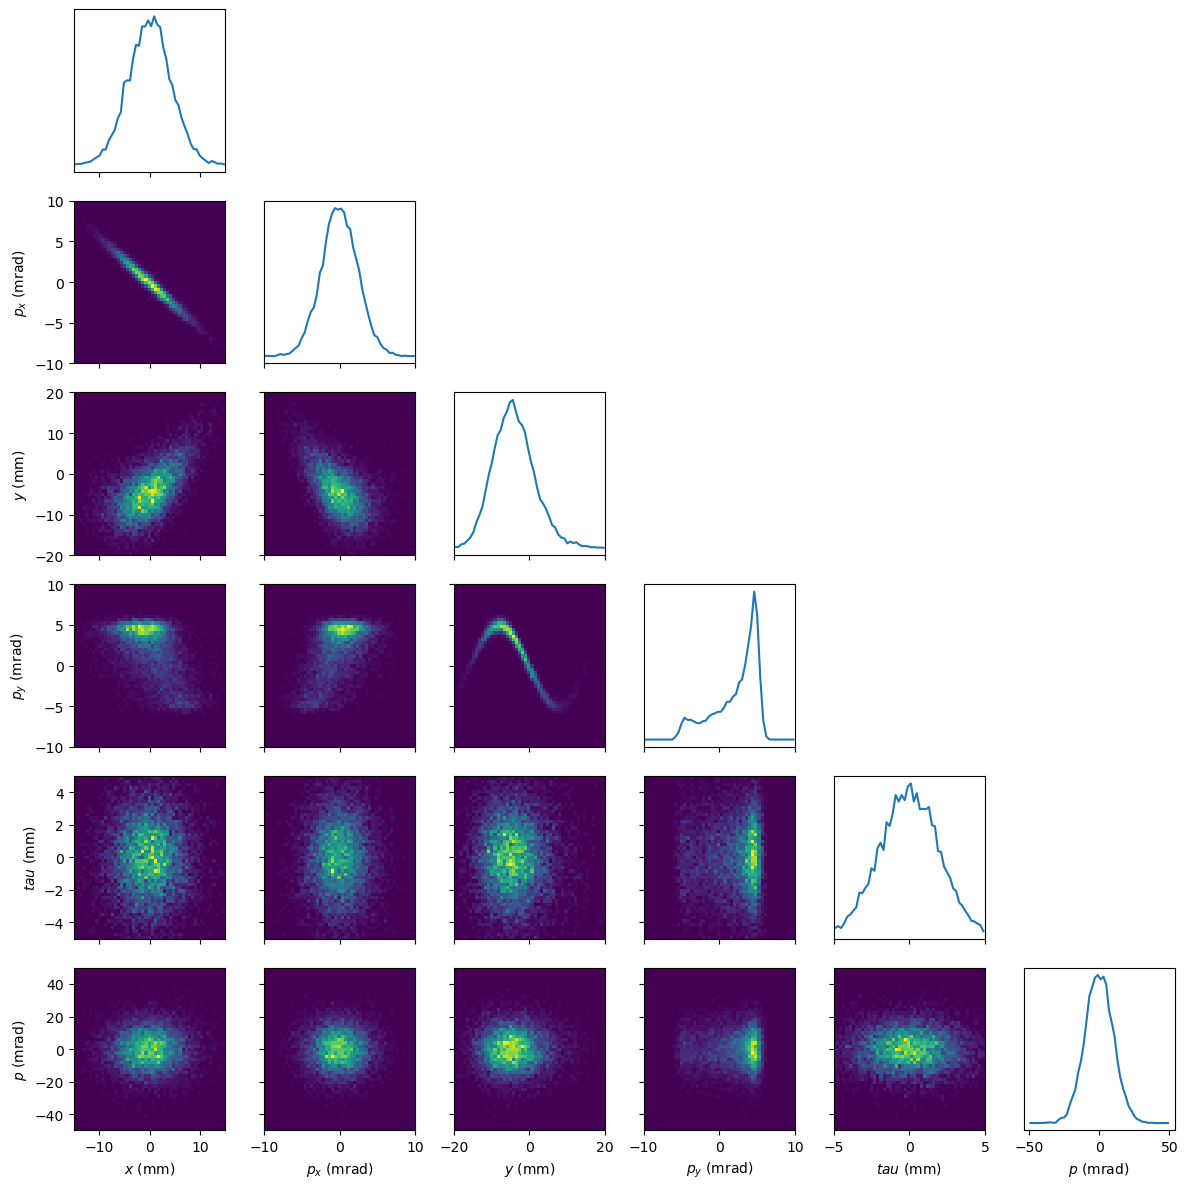

In [3]:
# plot synthetic ground truth beam projections
import numpy as np

lims = np.array(
    [
        [-15e-3, 15e-3],
        [-10e-3, 10e-3],
        [-20e-3, 20e-3],
        [-10e-3, 10e-3],
        [-5e-3, 5e-3],
        [-5e-2, 5e-2],
    ]
)
gt_beam.plot_distribution(custom_lims=lims);

In [4]:
# create diagnostic screen:
bins = torch.linspace(-30, 30, 200) * 1e-3
bandwidth = (bins[1] - bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

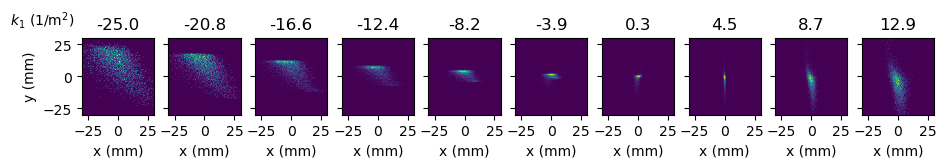

In [5]:
# create synthetic data
# get model
gpsr_lattice = GPSRQuadScanLattice(l_quad=0.1, l_drift=1.0, diagnostic=screen)

# quadrupole strengths for scan (reshape as: n_quad_strengths x n_images_per_quad_strength x 1)
n_ks = 20
ks = torch.linspace(-25, 15, n_ks)
gpsr_lattice.set_lattice_parameters(ks)

# propagate beam and get images
images = gpsr_lattice.track_and_observe(gt_beam)[0]

# split in training and testing sets
train_ks = ks[::2]
test_ks = ks[1::2]

train_images = images[::2]
test_images = images[1::2]

train_dset = FourDReconstructionDataset(train_ks, train_images, bins)
test_dset = FourDReconstructionDataset(test_ks, test_images, bins)

train_dset.plot_data();

In [6]:
torch.save(train_dset, "../test_data/test_datasets/reconstruction_4D_train.dset")
torch.save(test_dset, "../test_data/test_datasets/reconstruction_4D_test.dset")

RuntimeError: Parent directory ../test_data/test_datasets does not exist.

In [ ]:
gpsr_model = GPSR(NNParticleBeamGenerator(10000, p0c), gpsr_lattice)
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=20)

litgpsr = LitGPSR(gpsr_model)
logger = L.pytorch.loggers.TensorBoardLogger(
    ".",
)
trainer = L.Trainer(limit_train_batches=100, max_epochs=500, logger=logger)
trainer.fit(model=litgpsr, train_dataloaders=train_loader)

In [ ]:
reconstructed_beam = litgpsr.gpsr_model.beam_generator()

## Evaluate model on test samples to compare predictions

In [ ]:
test_pred = gpsr_model(test_ks)[0].detach()
test_pred_dset = FourDReconstructionDataset(test_ks, test_pred, bins)

In [ ]:
fig, ax = test_dset.plot_data(overlay_data=test_pred_dset)
fig.set_size_inches(20, 3)

In [ ]:
reconstructed_beam.plot_distribution(custom_lims=lims);